# Machine Learning in Telecommunications | Customer Churn Analysis

The goal of this project is to train a simple supervised model to predict customer churn, and reveal valuable insights that can be used to inform operational deciscions. For this particular model we will be utilizing the Orange Telecom Dataset.

**Project Objectives:**
1. Data Loading and Preprocessing
2. Exploratory Data Analysis
3. Train and evaluate a baseline Random Forest model
4. Tune and analyze the model
5. Draw conclusions and provide actionable business insights

In [ ]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.tree import plot_tree

## 1. Data Loading and Preprocessing

In this step, we load the telecom churn datasets and perform initial preprocessing.
This includes standardizing column names and converting binary categorical variables
into numeric format to support exploratory analysis and machine learning models.
No feature selection or modeling is performed at this stage.


In [ ]:
# -------------------------------
# 1. Load CSV files
# -------------------------------
train_df = pd.read_csv('churn-80.csv')
test_df = pd.read_csv('churn-20.csv')

# Strip spaces from column names
train_df.columns = train_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()

# -------------------------------
# 2. Convert boolean and yes/no columns
# -------------------------------
# Churn column (True/False) → 0/1
train_df['Churn'] = train_df['Churn'].map({True: 1, False: 0})
test_df['Churn'] = test_df['Churn'].map({True: 1, False: 0})

# Other yes/no columns → 0/1
for col in ['International plan', 'Voice mail plan']:
    train_df[col] = train_df[col].map({'yes': 1, 'no': 0})
    test_df[col] = test_df[col].map({'yes': 1, 'no': 0})

# -------------------------------
# 3. Define numeric features
# -------------------------------
numeric_features = [
    'Account length',
    'Area code',
    'International plan',
    'Voice mail plan',
    'Number vmail messages',
    'Total day minutes',
    'Total day calls',
    'Total day charge',
    'Total eve minutes',
    'Total eve calls',
    'Total eve charge',
    'Total night minutes',
    'Total night calls',
    'Total night charge',
    'Total intl minutes',
    'Total intl calls',
    'Total intl charge',
    'Customer service calls'
]

# -------------------------------
# 4. Separate features and target
# -------------------------------
X_train = train_df[numeric_features]
y_train = train_df['Churn']

X_test = test_df[numeric_features]
y_test = test_df['Churn']

# -------------------------------
# 5. Quick check
# -------------------------------
print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)
print("Churn distribution in training set:\n", y_train.value_counts())
print("Churn distribution in test set:\n", y_test.value_counts())

Training set shape: (2666, 18) (2666,)
Test set shape: (667, 18) (667,)
Churn distribution in training set:
 Churn
0    2278
1     388
Name: count, dtype: int64
Churn distribution in test set:
 Churn
0    572
1     95
Name: count, dtype: int64


## 2.1 Exploratory Data Analysis (EDA)

This section explores relationships between customer behavior and churn.
We examine distributions of key numerical features across churn outcomes
using boxplots, and analyze linear relationships between variables using
a correlation heatmap. The goal is to identify patterns, potential predictors,
and redundant features before modeling.

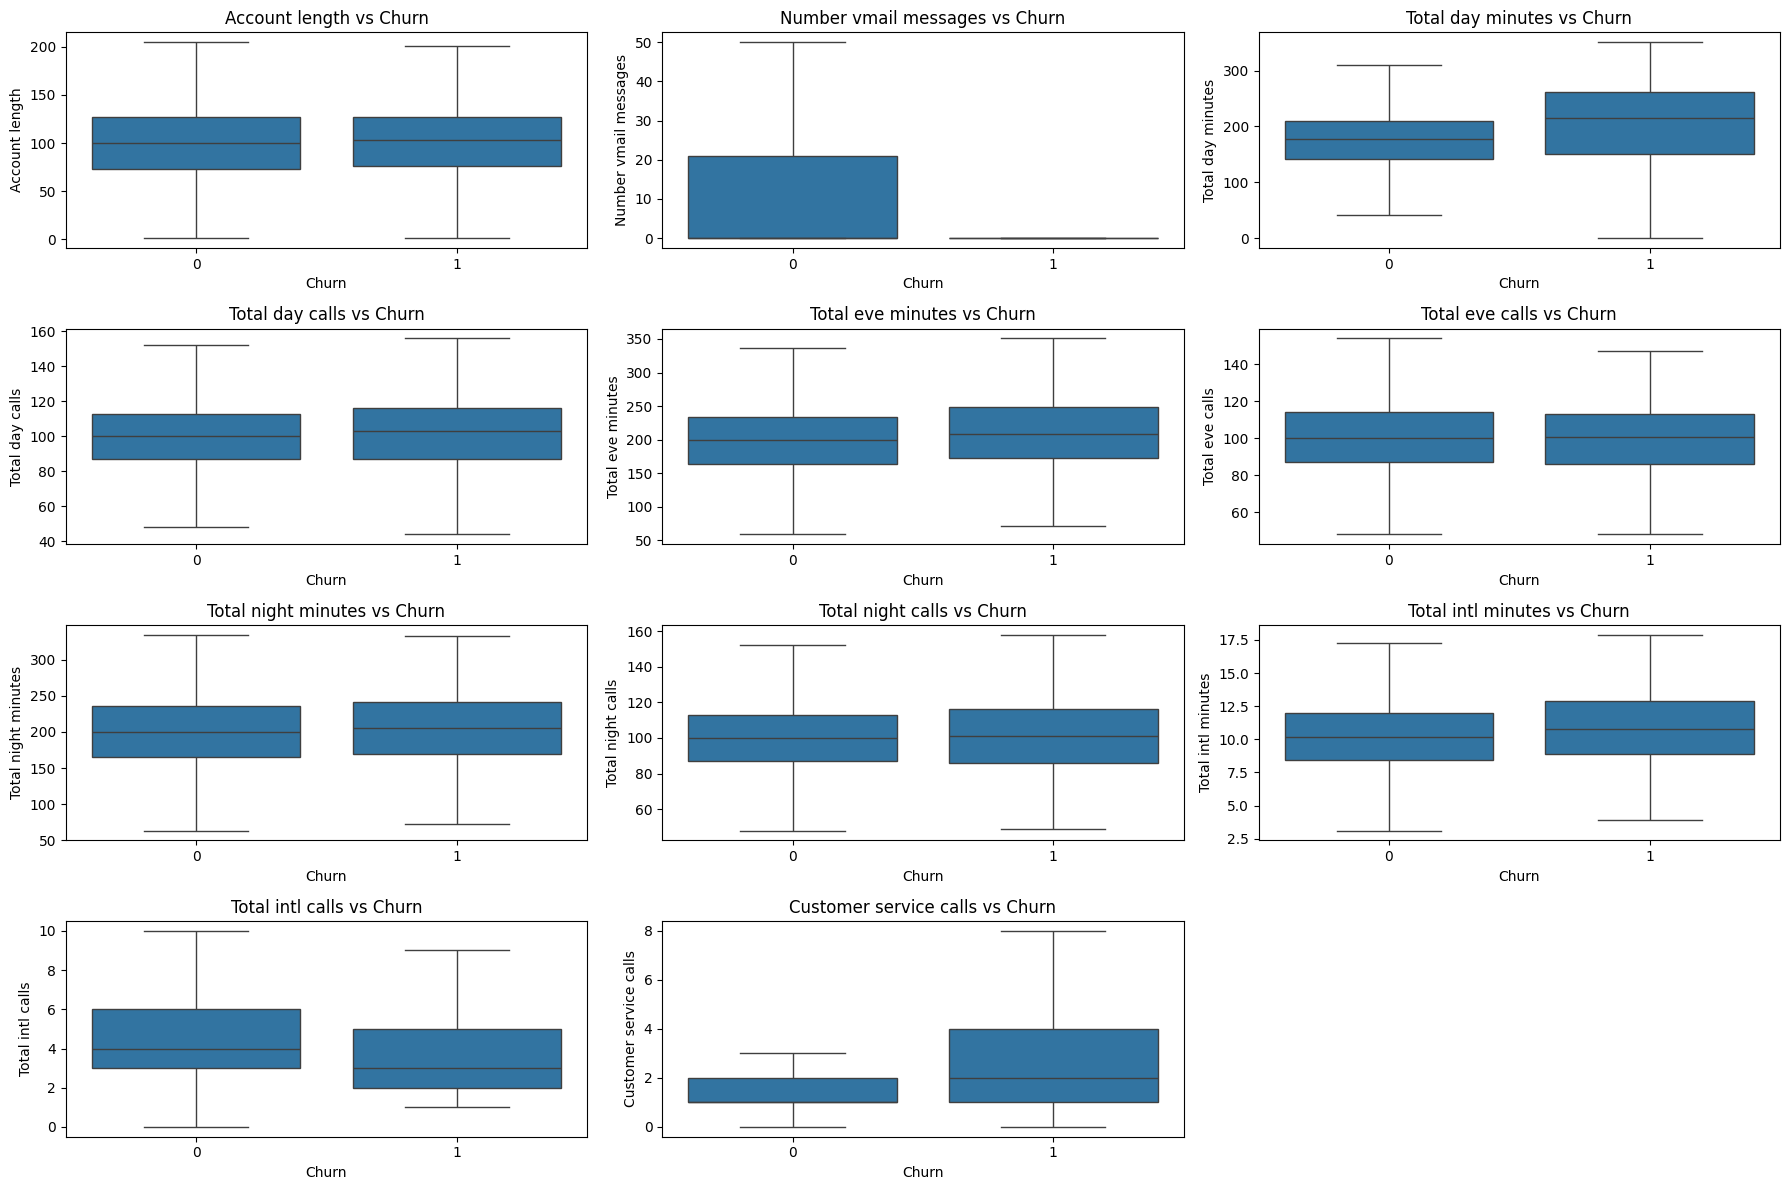

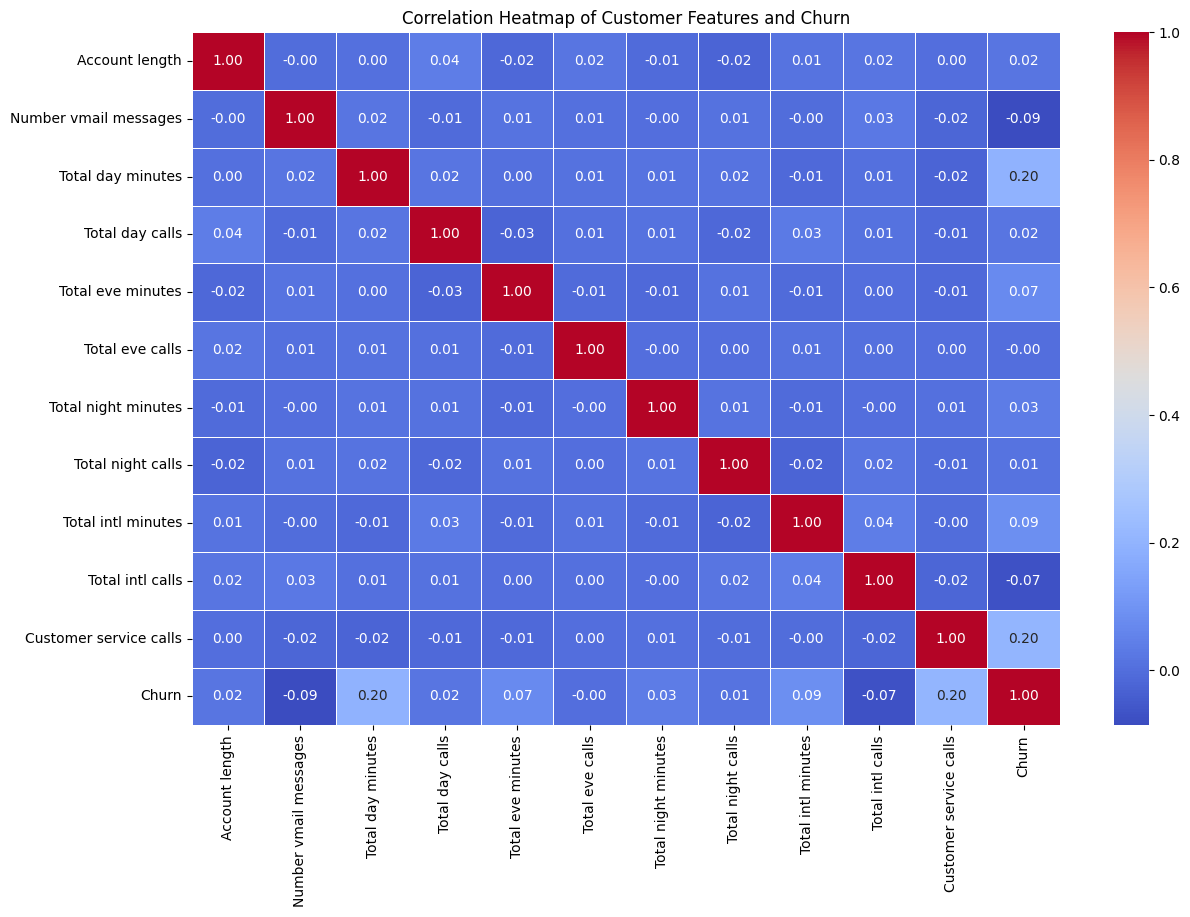

In [22]:
# ===============================
# Features to explore
# ===============================
eda_features = [
    'Account length',
    'Number vmail messages',
    'Total day minutes',
    'Total day calls',
    'Total eve minutes',
    'Total eve calls',
    'Total night minutes',
    'Total night calls',
    'Total intl minutes',
    'Total intl calls',
    'Customer service calls'
]

# ===============================
# Boxplots vs Churn
# ===============================
plt.figure(figsize=(18, 12))

for i, feature in enumerate(eda_features, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(
        data=train_df,
        x='Churn',
        y=feature,
        showfliers=False
    )
    plt.title(f'{feature} vs Churn')
    plt.xlabel('Churn')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

# ===============================
# Correlation Heatmap
# ===============================
corr_features = eda_features + [
    'Churn'
]

corr_matrix = train_df[corr_features].corr()

plt.figure(figsize=(14, 9))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    linewidths=0.5
)
plt.title('Correlation Heatmap of Customer Features and Churn')
plt.show()

## 2.2 Exploratory Data Analysis – Insights

The exploratory analysis reveals several meaningful patterns related to customer churn.

### Usage Patterns
Customers who churn tend to exhibit:
- Higher **total day minutes** and **total international minutes**, suggesting heavier usage may correlate with dissatisfaction or cost sensitivity.
- Increased **customer service calls**, which is one of the clearest behavioral indicators of churn and likely reflects unresolved service issues.

### Plan Characteristics
Customers subscribed to **international plans** show a noticeably higher churn rate. This may be due to higher costs associated with international usage or unmet expectations regarding plan value.

### Feature Relationships
The correlation heatmap highlights strong linear relationships between:
- Call minutes and corresponding charges (e.g., day minutes vs day charge), which is expected due to billing structure.
- Customer service calls and churn, reinforcing its predictive importance.

Highly correlated features (such as minutes and charges) suggest potential redundancy, which is acceptable for tree-based models but should be considered during interpretation.

### Key Takeaway
These findings suggest that churn is influenced by a combination of usage intensity, service friction, and plan structure. These insights will guide feature selection and model training in the next stage.

## 3.1 Baseline Random Forest Model

To quantify the insights from our exploratory analysis and predict customer churn, we will train a **baseline Random Forest classifier**. This model leverages the numeric and plan-related features identified during EDA to classify whether a customer is likely to churn.  

The objectives of this baseline model are:

- Establish a **performance benchmark** using our training (churn-80) and testing (churn-20) datasets.  
- Provide **initial evaluation metrics**, including accuracy, precision, recall, and F1-score, which will guide further tuning and refinement.  
- Visualize a **sample decision tree** to gain interpretability into how the Random Forest splits features to make predictions.  
- Perform **5-fold cross-validation**, a standard industry practice, to ensure that the model’s performance is robust across different subsets of the training data and not reliant on a specific split.

This baseline model serves as the foundation for subsequent improvements and hyperparameter tuning in order to **better detect churners**, particularly given the class imbalance observed in the dataset.

5-Fold CV Accuracy Scores: [0.90074906 0.92870544 0.91557223 0.92120075 0.92120075]
Mean CV Accuracy: 0.917
Std Dev CV Accuracy: 0.009

Accuracy on test set: 0.94

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       572
           1       0.98      0.60      0.75        95

    accuracy                           0.94       667
   macro avg       0.96      0.80      0.86       667
weighted avg       0.94      0.94      0.94       667



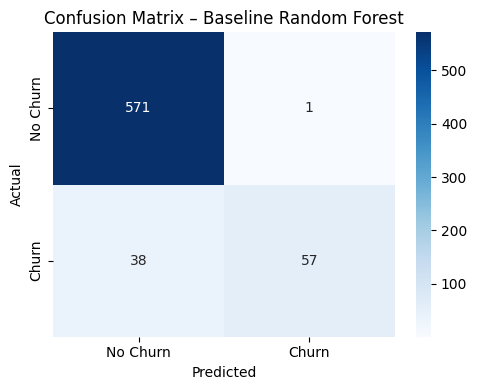

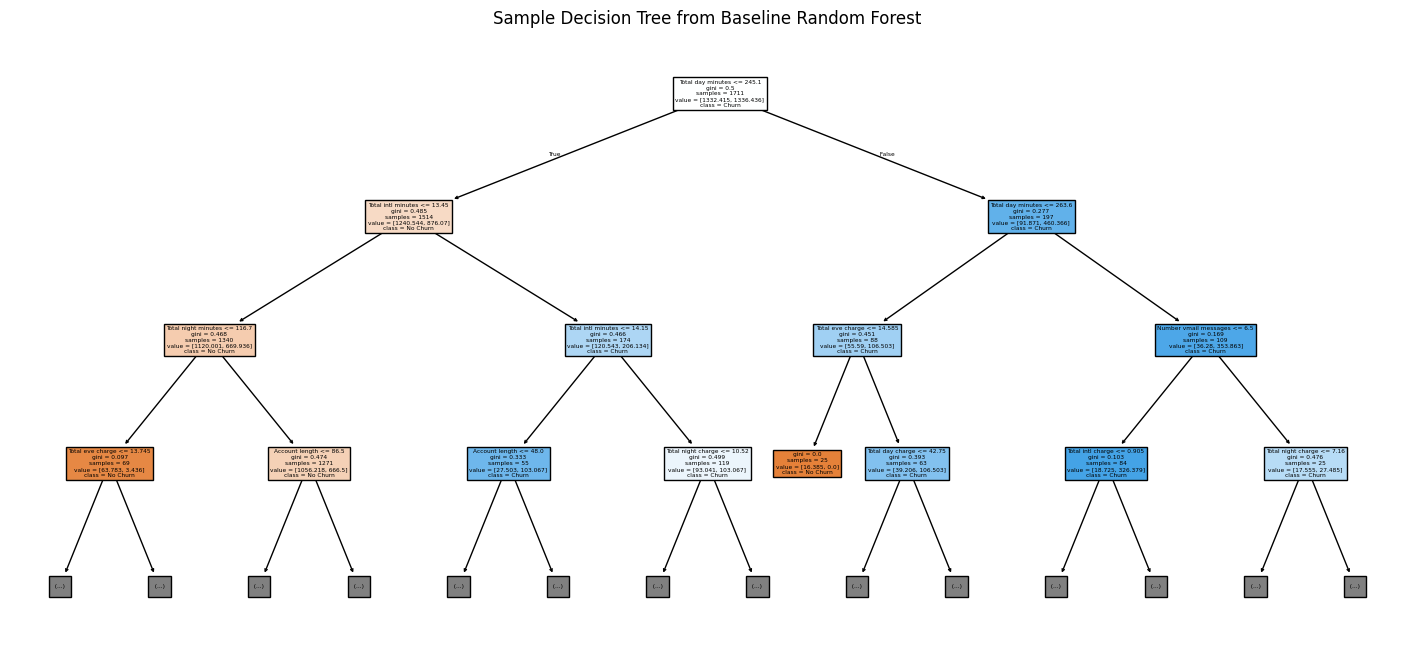

In [ ]:
# -------------------------------
# 1. Initialize baseline model
# -------------------------------
rf_baseline = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'  # handles churn imbalance professionally
)

# -------------------------------
# 2. K-Fold Cross-Validation (on training set)
# -------------------------------

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    rf_baseline,
    X_train,
    y_train,
    cv=kf,
    scoring='accuracy'
)

print("5-Fold CV Accuracy Scores:", cv_scores)
print(f"Mean CV Accuracy: {cv_scores.mean():.3f}")
print(f"Std Dev CV Accuracy: {cv_scores.std():.3f}\n")

# -------------------------------
# 3. Train on full training set (churn-80)
# -------------------------------
rf_baseline.fit(X_train, y_train)

# -------------------------------
# 4. Predict on test set (churn-20)
# -------------------------------
y_pred = rf_baseline.predict(X_test)

# -------------------------------
# 5. Evaluation metrics
# -------------------------------
print(f"Accuracy on test set: {accuracy_score(y_test, y_pred):.2f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['No Churn', 'Churn'],
    yticklabels=['No Churn', 'Churn']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – Baseline Random Forest')
plt.tight_layout()
plt.show()

# -------------------------------
# 6. Visualize a sample tree
# -------------------------------
plt.figure(figsize=(18,8))
plot_tree(
    rf_baseline.estimators_[0],
    feature_names=X_train.columns,
    class_names=['No Churn', 'Churn'],
    filled=True,
    max_depth=3
)
plt.title("Sample Decision Tree from Baseline Random Forest")
plt.show()


## 3.2 Baseline Random Forest – Performance Analysis

A baseline Random Forest model was trained on the churn-80 dataset and evaluated on the churn-20 holdout set to establish a performance benchmark before optimization.

### Model Reliability
To ensure the model generalizes beyond a single train–test split, **5-fold cross-validation** was applied on the training data.

- **Mean Cross-Validation Accuracy:** 0.917  
- **Standard Deviation:** 0.009  

The low variance across folds indicates consistent performance and suggests that the model is not overfitting. This validates the baseline model as a reliable starting point for further refinement.

### Test Set Performance
On the unseen test set, the model achieved:

- **Accuracy:** 0.94  
- **Churn Precision:** 0.98  
- **Churn Recall:** 0.60  

While overall accuracy is high, it is largely driven by correct predictions of non-churn customers. The recall score reveals that approximately **40% of churners are not being detected**, which limits the model’s effectiveness in a real-world retention context.

### Confusion Matrix Insights
The confusion matrix indicates that the majority of errors are **false negatives**—customers who churn but are predicted to stay. From a business perspective, this is the most costly type of error, as it represents missed opportunities to intervene and retain customers.

### Key Takeaway
The baseline Random Forest demonstrates strong stability and precision but underperforms in identifying all at-risk customers. Improving **churn recall and F1-score** is more valuable than further increasing overall accuracy and will be the primary focus of the next stage.

## 4.1 Random Forest Tuning – Methodology and Rationale

With a strong and stable baseline established, the next step is to improve model performance through **targeted hyperparameter tuning**.

### Why Tuning Is Necessary
Random Forests are robust by design, but their performance depends heavily on how individual trees are constructed and how the ensemble balances bias and variance. The baseline model favors conservative predictions, which contributes to high precision but lower recall for churn.

Tuning allows the model to:
- Capture more complex churn patterns  
- Reduce false negatives  
- Better align performance with business objectives  

### Tuning Approach
Rather than increasing model complexity indiscriminately, tuning will focus on controlling tree behavior and ensemble diversity. Key hyperparameters to be optimized include:

- **`max_depth`** – limits tree complexity to improve generalization  
- **`min_samples_leaf`** – prevents trees from learning noise  
- **`max_features`** – controls feature randomness to reduce correlation between trees  
- **`n_estimators`** – balances model stability and variance reduction  

### Evaluation Strategy
All tuning will be performed using **cross-validation on the training set only**, preserving the test set as a final, unbiased evaluation. Metrics such as **recall and F1-score for the churn class** will be prioritized during optimization, as they better reflect the cost of missed churn predictions.

### Outcome
This structured tuning process aims to produce a model that maintains stability while significantly improving its ability to identify customers at risk of churn—resulting in a more practical and business-relevant predictive system.

Best Hyperparameters:
{'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 100}

Accuracy on test set: 0.90

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       572
           1       0.62      0.75      0.68        95

    accuracy                           0.90       667
   macro avg       0.79      0.84      0.81       667
weighted avg       0.91      0.90      0.90       667



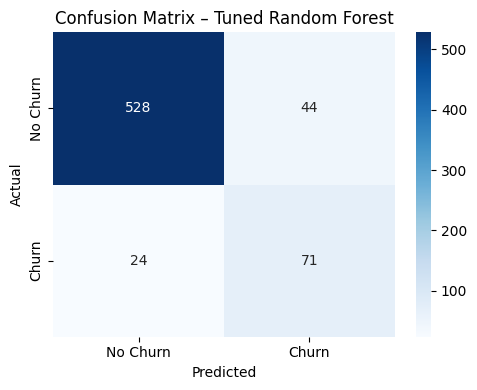

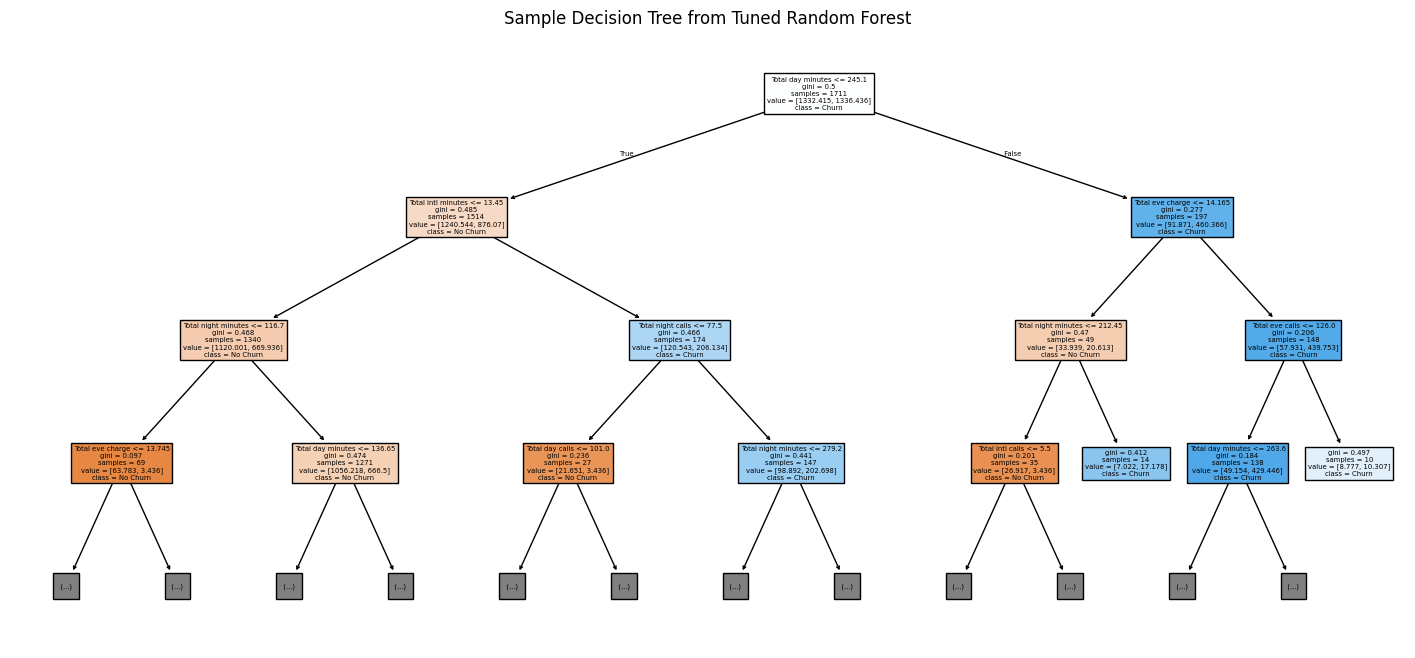

In [20]:
# -------------------------------
# 1. Hyperparameter grid
# -------------------------------
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 8, 12],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2']
}

# -------------------------------
# 2. Grid Search with CV
# -------------------------------
rf = RandomForestClassifier(
    random_state=42,
    class_weight='balanced'
)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='recall',   # prioritize catching churners
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Best model
rf_tuned = grid_search.best_estimator_

print("Best Hyperparameters:")
print(grid_search.best_params_)
print()

# -------------------------------
# 3. Predict on churn-20
# -------------------------------
y_pred_tuned = rf_tuned.predict(X_test)

# -------------------------------
# 4. Evaluation metrics
# -------------------------------
print(f"Accuracy on test set: {accuracy_score(y_test, y_pred_tuned):.2f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred_tuned))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tuned)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['No Churn', 'Churn'],
    yticklabels=['No Churn', 'Churn']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – Tuned Random Forest')
plt.tight_layout()
plt.show()

# -------------------------------
# 5. Visualize a tuned tree
# -------------------------------
plt.figure(figsize=(18,8))
plot_tree(
    rf_tuned.estimators_[0],
    feature_names=X_train.columns,
    class_names=['No Churn', 'Churn'],
    filled=True,
    max_depth=3
)
plt.title("Sample Decision Tree from Tuned Random Forest")
plt.show()

## 4.2 Tuned Random Forest – Performance Analysis

The Random Forest model was tuned using a grid search with 5-fold cross-validation, prioritizing **recall** to better capture churners. Hyperparameters were selected based on maximizing recall while maintaining general stability.

### Best Hyperparameters
The tuning process selected:
- **max_depth:** 8  
- **max_features:** sqrt  
- **min_samples_leaf:** 10  
- **n_estimators:** 100  

These settings balance complexity and overfitting, while keeping the individual trees interpretable.

### Test Set Performance
On the holdout churn-20 dataset, the tuned model achieved:

- **Accuracy:** 0.90  
- **Churn Recall:** 0.75  
- **Churn Precision:** 0.62  
- **F1-score for Churn:** 0.68  

Compared to the baseline, recall for churn increased substantially (from 0.60 → 0.75), indicating the model now identifies a higher proportion of actual churners. Precision decreased slightly, reflecting more false positives, but this is acceptable in a business context since **catching churners is more critical than avoiding false alarms**.

### Confusion Matrix Insight

- **False negatives** (24) have decreased from the baseline, meaning fewer churners are missed.  
- **False positives** (44) have slightly increased, which is tolerable because these customers can be targeted for retention campaigns without significant cost.

### Key Takeaways
- Tuning improved **churn recall**, aligning the model with business priorities.  
- Precision–recall tradeoff is managed deliberately: capturing more churners comes at the cost of some false positives.  
- Sample decision trees remain interpretable, and feature importance can be examined to guide business interventions.

## 5. Feature Importance & Business Insights

After tuning the Random Forest, we examine **feature importances** to understand which factors most strongly influence customer churn. This step provides actionable insights for the business and demonstrates interpretability of the model.

### Top Features Driving Churn
Based on the tuned Random Forest, the most important features include:

1. **Customer Service Calls** – Consistently the strongest predictor. Customers with higher service interactions are more likely to churn, highlighting unresolved issues or dissatisfaction.
2. **Total Day Minutes / Total International Minutes** – Heavier usage patterns correlate with churn, suggesting that high-usage customers may be more sensitive to plan costs or service quality.
3. **International Plan** – Subscription to international plans increases churn probability, indicating potential pricing or value misalignment.
4. **Number of Voicemail Messages** – Lower or irregular voicemail usage can indicate disengagement from the service.

> These insights are valuable for designing retention campaigns, adjusting pricing or plan offerings, and proactively addressing customer issues.

### Business Implications
- **Retention Focus:** Target customers with high service calls and heavy usage for retention interventions.  
- **Plan Design:** Reassess the value of international plans and pricing structures.  
- **Customer Experience:** Reduce friction in customer service interactions to lower churn risk.  

### Summary
The combination of **data-driven modeling** and **feature interpretability** allows businesses to:
- Predict churn effectively  
- Understand underlying causes  
- Take actionable steps to reduce customer attrition  

This analysis completes the end-to-end modeling pipeline, demonstrating a professional approach from **EDA → Baseline Model → Tuning → Feature Interpretation**, suitable for portfolio presentation.